In [5]:
import os
import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle

In [6]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

In [7]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [8]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [9]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [10]:
def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [11]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [12]:
LOAD_CLUSTERS_DATA = True

In [13]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_rus_usernames:
        ukraine_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_ukr_usernames:
        ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [14]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [15]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [16]:
if not LOAD_CLUSTERS_DATA:
    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [17]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [36]:
def get_user_followers(user_name, user_id, num_pages=1):
    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes
    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = 1000, limit = num_pages).flatten()
    for follower in followers_paginator:
        followers.append(follower)
    return (user_name, user_id), followers

In [98]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [37]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [25]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

'''
for cluster in russia_sources_rus:
    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_rus:
    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_ukr:
    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_eng:
    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))
'''

'\nfor cluster in russia_sources_rus:\n    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_rus:\n    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_ukr:\n    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_eng:\n    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n'

In [38]:
# TEST CODE: 1000 followers per cluster, 2 cluster per each
for i in range(0, 2):
    rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

for i in range(0, 2):
    ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))

In [39]:
print(ukr_eng_cluster_followers)

[(('@dmitry_gordon', 1334400780), [<User id=2980453289 name=Andris Tobiess username=ATobiess>, <User id=1596571789777403907 name=Oleg Shkel username=shkeleek>, <User id=1596978086255493120 name=Kakhaber Guchmanidze username=KakhaberGuchma2>, <User id=1589385672963547136 name=Андрій 🇺🇦🇺🇸🇬🇧🇨🇦🇪🇺 username=Actek_tapat8>, <User id=1594454692456763393 name=دارين username=Zlata89530677>, <User id=1596976431963295744 name=Олександр Діденко username=OleksandrDidan>, <User id=1594583115380379648 name=Natasha Andrews username=NatshaaAndrews>, <User id=1592588772931244035 name=Tatiana Shevchuk username=TatianaShevchu9>, <User id=1596975648798609411 name=Stas Bojko username=StasBojko7>, <User id=1596975868437487616 name=liliia username=liliia39009003>, <User id=1596967201705279490 name=Андрій Совтус username=SovtusAndrij>, <User id=1401158143208472577 name=JeSeTeR username=JeSeTeR6>, <User id=1596963307679891461 name=kraizi top username=KraiziT>, <User id=1596963805694763010 name=Элоиза username=loi

In [71]:
'''
print(type(followers[('@minregion_ua', 3333475643)][0]))
print(followers[('@minregion_ua', 3333475643)][0].name)
print(followers[('@minregion_ua', 3333475643)][0].id)
'''

<class 'tweepy.user.User'>
Ігор Зірчак
1596438068617269248


In [62]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [63]:
def cluster_to_df(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [129]:
rus_cluster = cluster_to_df(rus_cluster_followers)
ukr_eng_cluster = cluster_to_df(ukr_eng_cluster_followers)
ukr_rus_cluster = cluster_to_df(ukr_rus_cluster_followers)
ukr_ukr_cluster = cluster_to_df(ukr_ukr_cluster_followers)

In [75]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [77]:
clusters_to_files(rus_cluster)
clusters_to_files(ukr_eng_cluster)

<h2>Visualizing Connections as a Graph</h2>

In [88]:
ukr_eng_cluster[('@dmitry_gordon',
  1334400780)]

,username,user_id
0,Andris Tobiess,2980453289
1,Oleg Shkel,1596571789777403907
2,Kakhaber Guchmanidze,1596978086255493120
3,Андрій 🇺🇦🇺🇸🇬🇧🇨🇦🇪🇺,1589385672963547136
4,دارين,1594454692456763393
...,...,...
995,Radha,1577173525110087681
996,Oleg,419693918
997,Laila Zahid,1496770149210374144
998,Coreyeyopina,1594522415077408769


In [92]:
import networkx as nx

In [152]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [153]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [169]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

In [154]:
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster",
                                              global_graph_pd)

In [158]:
print(global_graph_pd.size)
print(global_graph_pd.tail())

11994
             username              user_id   cluster_name cluster_id  \
994     Адилет Опышев  1595854642612690951  @SvobodaRadio   47562921   
995  Сахит Даулетбаев  1595852972486959104  @SvobodaRadio   47562921   
996     Ваня Гончаров  1595850768812281858  @SvobodaRadio   47562921   
997        senya pier  1595849718898343938  @SvobodaRadio   47562921   
998      MHD_BANOCHKA  1595849682286268417  @SvobodaRadio   47562921   

    cluster_follow_count group_id  
994               491161        1  
995               491161        1  
996               491161        1  
997               491161        1  
998               491161        1  


In [93]:
# G = nx.from_pandas_edgelist(ukr_eng_cluster[('@dmitry_gordon',
#   1334400780)], 'username', 'user_id')
# pos = nx.spring_layout(G)

In [182]:
print("Constructing NetworkX graph")

G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


Visualizing a small subset of connections...


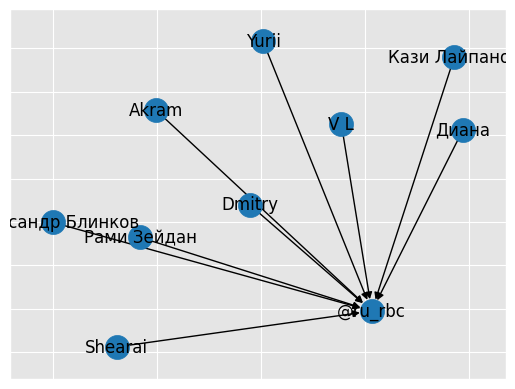

In [183]:
print("Visualizing a small subset of connections...")

subgraph = G.subgraph(list(G.nodes)[:10])

subgraph_pos = nx.spring_layout(subgraph)

nx.draw_networkx(subgraph, subgraph_pos)


<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing?
2. Tag Cloud: who are people within each group discussing?
3. What sentiment do mentions within each groups have?
4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)


In [ ]:
print("Running analysis on the network...")



/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127464 (\N{REGIONAL INDICATOR SYMBOL LETTER C}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128038 (\N{BIRD}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_

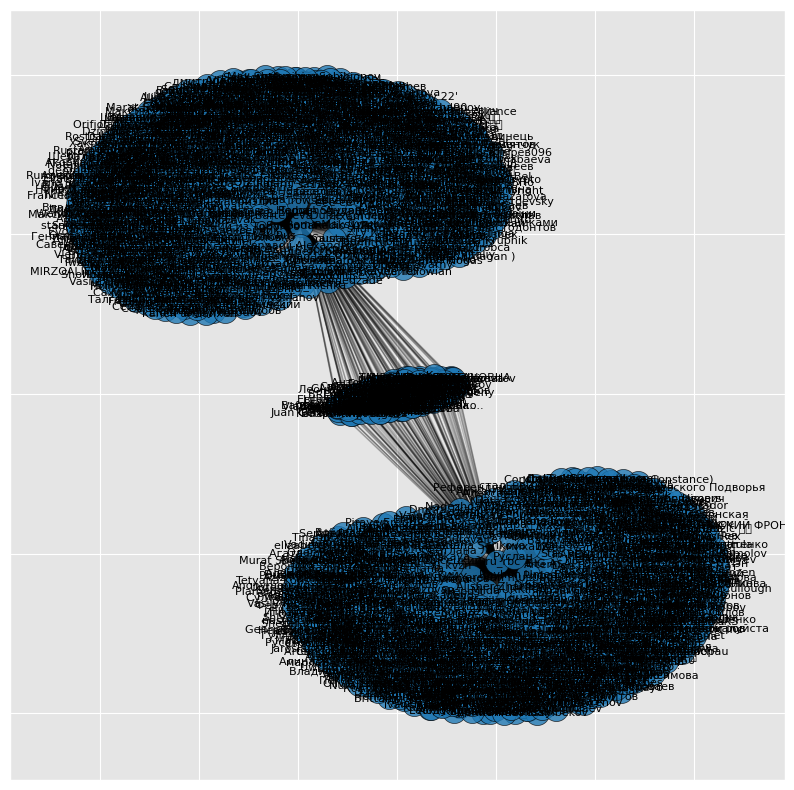

In [164]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

In [ ]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

<h2>Visualizing the Network using Gephi</h2>

In [ ]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group